In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
import seaborn as sns
import re
import json
import requests
import subprocess
import glob
import os
import geopandas as gpd
from geopandas import GeoDataFrame
from pygeocoder import Geocoder
import scikit_posthocs as sp
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
import folium
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
#import tensorflow
#import imblearn
#from imblearn.over_sampling import SMOTE

In [54]:
#!pip install folium
#!pip install plotly
#!pip install scikit-posthocs
#!pip install tensorflow (to fix imblearn package issue using SMOTE)


In [55]:
#Load cleaned dataset from 1st file of code (1of2)
tow = pd.read_csv('/Users/elizabethclick/Desktop/DATA205/tow_clean.csv')
tow.drop(tow[tow['hh_income'] < 0].index, inplace = True)
tow.head()

,tow_date,tow_reason,storage_company,street,city,geo_location,longitude,latitude,location,block,hh_income,pop_total,pop_black,state,tract
0,2020-12-11,REPO,Final Notice,21704 Stableview Dr,Gaithersburg,POINT (-77.175624 39.211873),-77.175624,39.211873,"(39.211873, -77.175624)",7001012,208929,1931,39,24,700101
1,2021-02-17,REPO,NaN,8212 Brink Rd,Gaithersburg,POINT (-77.167752 39.208712),-77.167752,39.208712,"(39.208712, -77.167752)",7001013,135208,800,10,24,700101
2,2021-02-10,REPO,Thomas,7321 Brink Rd,Gaithersburg,POINT (-77.148754 39.211605),-77.148754,39.211605,"(39.211605, -77.148754)",7001013,135208,800,10,24,700101
3,2020-02-15,REPO,Greenwood Recovery,21400 Laytonsville Rd,Gaithersburg,POINT (-77.141329 39.207148),-77.141329,39.207148,"(39.207148, -77.141329)",7001032,218173,1017,193,24,700103
4,2020-02-04,REPO,Greenwood Recovery,7571 Lindbergh Dr,Gaithersburg,POINT (-77.153158 39.166038),-77.153158,39.166038,"(39.166038, -77.153158)",7001033,172778,3112,345,24,700103


In [56]:
#COUNTS ARE IMPORTANT TO BE AWARE OF - keep checking throughout
print("number of tows: ", len(tow))
print("number of unique blocks: ", len(tow["block"].unique()))
print("number of unique geo_codes", len(tow["geo_location"].unique()))
#hh_income, pop_total, and pop_black wil be duplicated as is corresponds to each for each block number 
#that is also duplicated among the 19,753 property addresses which can also repeat. DO NOT SUM except 
#tow column counts


number of tows:  19753
number of unique blocks:  470
number of unique geo_codes 5881


In [57]:
print(tow.shape)
print(tow[tow["storage_company"] == "Other"])

(19753, 15)
         tow_date tow_reason storage_company                  street  \
15     2020-08-02        PRV           Other  7501 Muncaster Mill Rd   
16     2020-08-12       FIRE           Other    17612 Phelps Hill Ln   
18     2020-12-20       REPO           Other  6314 Holland Meadow Ln   
21     2021-01-04       REPO           Other         7230 Antares Dr   
84     2020-12-03       REPO           Other        9214 Chadburn Pl   
...           ...        ...             ...                     ...   
19868  2021-01-23       REPO           Other      12122 Bentridge Pl   
19960  2020-08-13        NOP           Other       10524 Westlake Dr   
19964  2020-12-10        NOP           Other       10405 Westlake Dr   
19966  2021-02-01        PKG           Other     10400 Auto Park Ave   
19972  2021-01-23       REPO           Other       10518 Westlake Dr   

                     city                  geo_location  longitude   latitude  \
15           Gaithersburg  POINT (-77.1535

In [58]:
#load data to geodataframe for mapping all properties
tow_gpd = gpd.GeoDataFrame(tow, geometry=gpd.points_from_xy(tow.latitude, tow.longitude))
tow_gpd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 19753 entries, 0 to 19974
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   tow_date         19744 non-null  object  
 1   tow_reason       19737 non-null  object  
 2   storage_company  19004 non-null  object  
 3   street           19753 non-null  object  
 4   city             19753 non-null  object  
 5   geo_location     19753 non-null  object  
 6   longitude        19753 non-null  float64 
 7   latitude         19753 non-null  float64 
 8   location         19753 non-null  object  
 9   block            19753 non-null  int64   
 10  hh_income        19753 non-null  int64   
 11  pop_total        19753 non-null  int64   
 12  pop_black        19753 non-null  int64   
 13  state            19753 non-null  int64   
 14  tract            19753 non-null  int64   
 15  geometry         19753 non-null  geometry
dtypes: float64(2), geometry(1), int6

In [59]:
#produce heatmap of all properties
import folium
from folium.plugins import MarkerCluster

mc = folium.Map(location=[39.211873, -77.175624],
                     tiles='stamentoner',
                     zoom_start=12,max_bounds=True)

marker_cluster = folium.plugins.MarkerCluster()

#Create a list of coordinate for heatmap input
mc_points = list(zip(tow_gpd["latitude"], tow_gpd["longitude"]))
from folium.plugins import HeatMap
HeatMap(mc_points).add_to(folium.FeatureGroup(name='Heat Map').add_to(mc))
folium.LayerControl().add_to(mc)

mc


In [60]:
#GROUP BLOCKS INTO CITIES: SUM TOW COLUMN COUNTS 
#Set constants by dropping duplicte block codes to get pop_totals for each city
pop_sort = tow.sort_values(["block"]).drop_duplicates(subset = 'pop_total', keep='first').reset_index() 
#calculate total population using blocks data and the unique pop_total isolated in the above line of code
dataset_population = sum(pop_sort["pop_total"]) 
dataset_blackpop = sum(pop_sort["pop_black"]) 
print('Total Subset MC population in Dataset = ', dataset_population) 
print('Total Subset MC black population = ', dataset_blackpop)
pop_sort["pop_white"] = pop_sort["pop_total"] - pop_sort["pop_black"]
print(pop_sort.head())

#total city populations: refer back to this dataframe and sum the blocks pop_sort city_names = pd.Series(pop_sort['city'].unique()) city_names
city_melt = pd.melt(pop_sort, id_vars="city", value_vars=["pop_total", "pop_black", "pop_white"], var_name=None, value_name='value', col_level=None, ignore_index=True)
city_popvals = city_melt.groupby(["city","variable"]).agg(sum_col=pd.NamedAgg(column="value", aggfunc="sum")) 

city_popvals = city_popvals.reset_index()
print(city_popvals)
city_popvals = city_popvals.pivot(index='city', columns=["variable"])
#city_popvals = pd.DataFrame(city_popvals)
#city_popvalsdf = pd.DataFrame(reshaped_city_popvals)
#city_popvalsdf = city_popvalsdf.columns.droplevel(0)
city_names = pd.Series(city_popvals.index)
city_names



Total Subset MC population in Dataset =  800033
Total Subset MC black population =  171238
   index    tow_date tow_reason     storage_company                 street  \
0      0  2020-12-11       REPO        Final Notice    21704 Stableview Dr   
1      1  2021-02-17       REPO                 NaN          8212 Brink Rd   
2      3  2020-02-15       REPO  Greenwood Recovery  21400 Laytonsville Rd   
3     21  2021-01-04       REPO               Other        7230 Antares Dr   
4     45  2020-07-28        DAV          Authorized      20139 Welbeck Ter   

                 city                  geo_location  longitude   latitude  \
0        Gaithersburg  POINT (-77.175624 39.211873) -77.175624  39.211873   
1        Gaithersburg  POINT (-77.167752 39.208712) -77.167752  39.208712   
2        Gaithersburg  POINT (-77.141329 39.207148) -77.141329  39.207148   
3        Gaithersburg  POINT (-77.149128 39.161573) -77.149128  39.161573   
4  Montgomery Village  POINT (-77.182915 39.186604) -77

0               Bethesda
1                  Boyds
2            Brookeville
3           Burtonsville
4             Cabin John
5            Chevy Chase
6             Clarksburg
7               Damascus
8                Derwood
9           Gaithersburg
10          Garrett Park
11            Germantown
12            Kensington
13    Montgomery Village
14                 Olney
15           Poolesville
16               Potomac
17             Rockville
18          Sandy Spring
19         Silver Spring
20           Takoma Park
Name: city, dtype: object

In [61]:
#Check city demographic sums to be sure they are correct and put in dataframe df_test
test = np.array(city_popvals)
df_test = pd.DataFrame(test)
df_test
df_test = df_test.rename(columns = {0 : "pop_black",
                            1 : "pop_total",
                            2 : "pop_white"})
df_test["city"] = ['Bethesda', 'Boyds', 'Brookeville', 'Burtonsville', 'Cabin John',
       'Chevy Chase', 'Clarksburg', 'Damascus', 'Derwood', 'Gaithersburg',
       'Garrett Park', 'Germantown', 'Kensington', 'Montgomery Village',
       'Olney', 'Poolesville', 'Potomac', 'Rockville', 'Sandy Spring', 'Silver Spring',
       'Takoma Park']
df_test
sum(df_test["pop_total"]) #check that population was correctly summed - yes

800033

In [62]:
## WHAT AREAS EXPERIENCE THE MOST TOWING
#subset cities with over 200 towings for the year
tow_city=tow['city'].value_counts()#[tow['city'].value_counts()> 200]
city_count = tow["city"].value_counts()
city_freq = tow["city"].value_counts(normalize = True)
#make a new dataframe with values from counts and city population values above
city_df = pd.DataFrame(tow_city, tow_city.index)
city_df = city_df.rename(columns={'city': 'tow_count'})

city_df = city_df.reset_index()
city_df = city_df.rename(columns={'index': 'city'})
print(city_df)
print(df_test)
city_uniform = city_df.merge(right = df_test, how='inner', on="city", left_on=None, right_on=None, left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)

city_uniform["tow_rate"] = city_uniform["tow_count"] / city_uniform["pop_total"]
print(sum(city_uniform["pop_total"]))
print(sum(city_uniform["pop_black"]))

                  city  tow_count
0        Silver Spring       8455
1         Gaithersburg       3232
2           Germantown       2476
3            Rockville       1896
4   Montgomery Village       1738
5             Bethesda        561
6          Takoma Park        331
7         Burtonsville        321
8             Damascus        164
9              Derwood        160
10               Olney        143
11         Chevy Chase        124
12          Kensington         61
13          Clarksburg         44
14             Potomac         30
15               Boyds          6
16         Brookeville          5
17         Poolesville          3
18        Sandy Spring          1
19        Garrett Park          1
20          Cabin John          1
    pop_black  pop_total  pop_white                city
0        2503      40164      37661            Bethesda
1         754       5762       5008               Boyds
2         162       3004       2842         Brookeville
3        6320      13031    

In [63]:
print(len(city_df))
print(len(city_uniform))

21
21


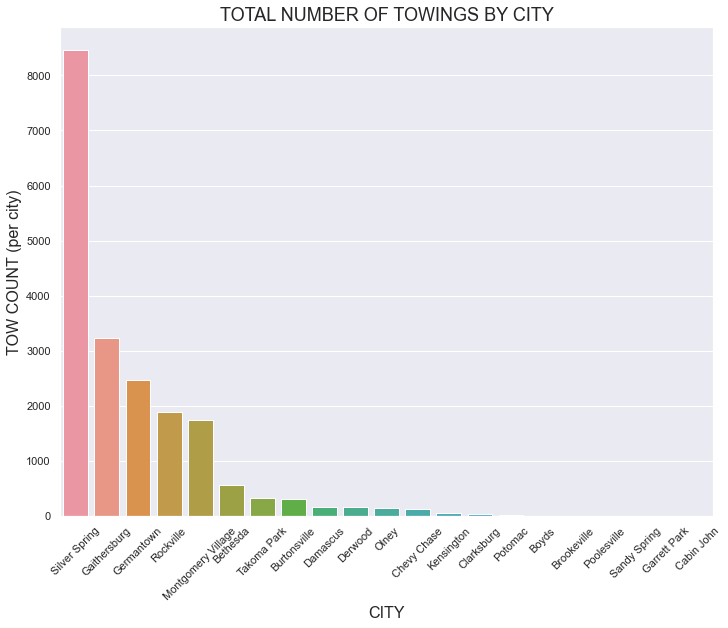

<Figure size 842.4x648 with 0 Axes>

In [64]:
#visualization of towing by city: Chose top 5 to examine further
sns.set(font_scale=3.0)
sns.set(rc={'figure.figsize':(11.7,9)})
sns.barplot(x="city", y="tow_count", data = city_uniform)
plt.title("TOTAL NUMBER OF TOWINGS BY CITY", fontsize=18)
plt.xlabel("CITY", fontsize=16)
plt.ylabel("TOW COUNT (per city)", fontsize=16)
plt.xticks(rotation=45)
plt.savefig('cityCOUNT_bar.png')
plt.show()
plt.tight_layout()


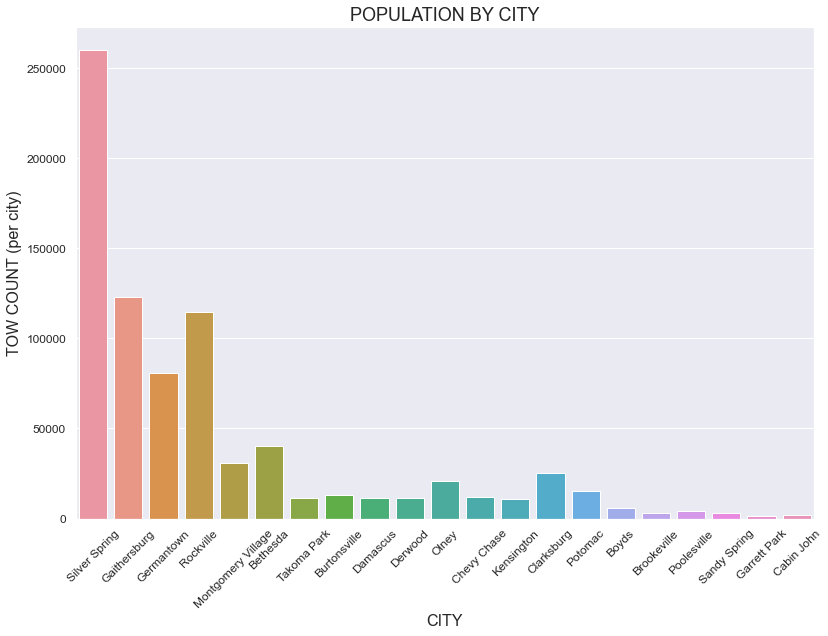

In [65]:
#visualization of towing by city: Chose top 5 to examine further
sns.set(font_scale=3.0)
sns.set(rc={'figure.figsize':(11.7,9)})
sns.barplot(x="city", y="pop_total", data = city_uniform)
plt.title("POPULATION BY CITY", fontsize=18)
plt.xlabel("CITY", fontsize=16)
plt.ylabel("TOW COUNT (per city)", fontsize=16)
plt.xticks(rotation=45)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('city_POP.png')
plt.show()

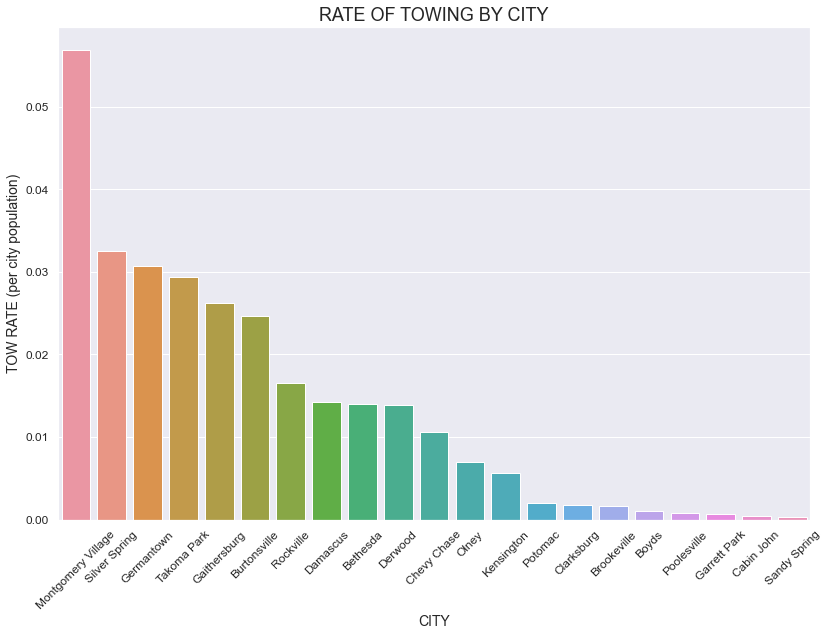

In [66]:
#visualization of towing by city: Chose top 5 to examine further
city_uniform = city_uniform.sort_values(by = ["tow_rate"], ascending=False)
sns.set(rc={'figure.figsize':(11.7,9)})
sns.barplot(x="city", y="tow_rate", data = city_uniform)
plt.title("RATE OF TOWING BY CITY", fontsize=18)
plt.xlabel("CITY", fontsize=14)
plt.ylabel("TOW RATE (per city population)", fontsize=14)
plt.xticks(rotation=45)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('cityRATE_bar.png')
plt.show()

In [67]:
##WHAT IS THE MOST COMMON REASON FOR TOWING?
tow_code=tow['tow_reason'].value_counts(normalize = True)[tow['tow_reason'].value_counts(normalize = True)> 0.0099]
reason_count = tow["tow_reason"].value_counts()
reason_freq = tow["tow_reason"].value_counts(normalize = True)
print(reason_freq)
tow_code


NOP                                       0.508791
PKG                                       0.204945
PRV                                       0.087653
REPO                                      0.072250
FIRE                                      0.056848
                                            ...   
NO COMMERCIAL                             0.000051
NO OPEN BED PICK UPS ALLOWED ON PROPER    0.000051
PKG`                                      0.000051
NO VISITOR                                0.000051
NOT PARKED IN A MARKED SPACE              0.000051
Name: tow_reason, Length: 215, dtype: float64


NOP     0.508791
PKG     0.204945
PRV     0.087653
REPO    0.072250
FIRE    0.056848
EXP     0.027056
Name: tow_reason, dtype: float64

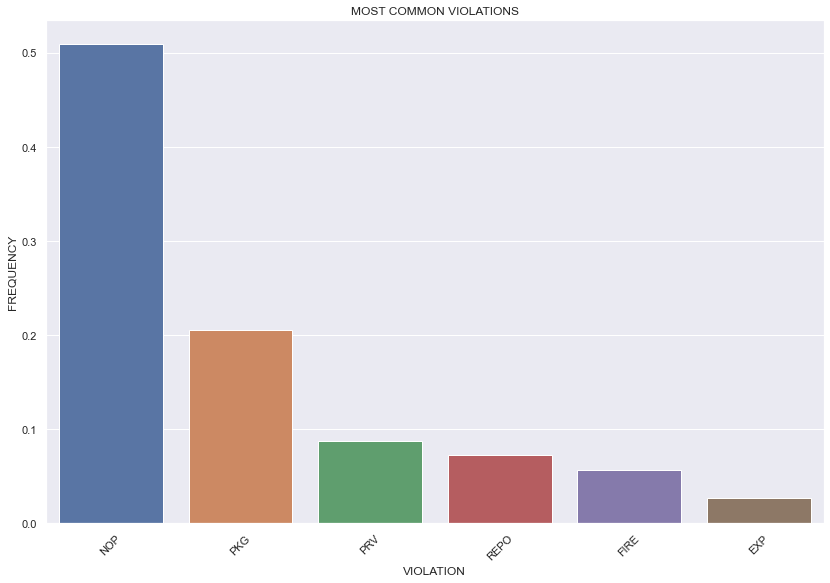

In [68]:
#visualization of towing by reason
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x=tow_code.index, y=tow_code)
plt.title("MOST COMMON VIOLATIONS")
plt.xlabel("VIOLATION")
plt.ylabel("FREQUENCY")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('violation_bar.png')
plt.show()

In [69]:
##WHICH COMPANIES ARE TOWING AND ARE THERE DISCREPANCIES?
tow_company=tow['storage_company'].value_counts(normalize = True)[tow['storage_company'].value_counts(normalize = True)> 0.01]
company_count = tow["storage_company"].value_counts()
company_freq = tow["storage_company"].value_counts(normalize = True)
print(company_freq)
tow_company

Henrys                    0.317302
Authorized                0.161703
Prestige                  0.087350
Speedy                    0.053252
Other                     0.050516
                            ...   
Dm Discount Auto Sales    0.000053
Authorized`               0.000053
Henys                     0.000053
Henrys`                   0.000053
The Lending Advantage     0.000053
Name: storage_company, Length: 264, dtype: float64


Henrys         0.317302
Authorized     0.161703
Prestige       0.087350
Speedy         0.053252
Other          0.050516
Drive          0.044622
Diversified    0.026258
Auburn         0.023206
Big            0.021311
Led            0.012471
Custom         0.012313
Name: storage_company, dtype: float64

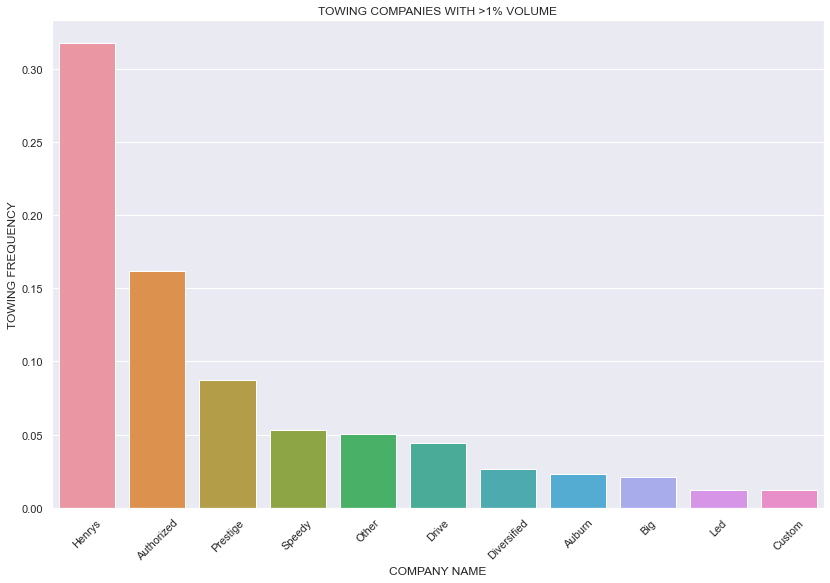

In [70]:
#Visualization of towing by company
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x=tow_company.index, y=tow_company)
plt.title("TOWING COMPANIES WITH >1% VOLUME")
plt.xlabel("COMPANY NAME")
plt.ylabel("TOWING FREQUENCY")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('company_bar.png')
plt.show()

In [71]:
#838 companies still listed as Tcl could not be identified
print(tow[tow["storage_company"] == "Other"])

         tow_date tow_reason storage_company                  street  \
15     2020-08-02        PRV           Other  7501 Muncaster Mill Rd   
16     2020-08-12       FIRE           Other    17612 Phelps Hill Ln   
18     2020-12-20       REPO           Other  6314 Holland Meadow Ln   
21     2021-01-04       REPO           Other         7230 Antares Dr   
84     2020-12-03       REPO           Other        9214 Chadburn Pl   
...           ...        ...             ...                     ...   
19868  2021-01-23       REPO           Other      12122 Bentridge Pl   
19960  2020-08-13        NOP           Other       10524 Westlake Dr   
19964  2020-12-10        NOP           Other       10405 Westlake Dr   
19966  2021-02-01        PKG           Other     10400 Auto Park Ave   
19972  2021-01-23       REPO           Other       10518 Westlake Dr   

                     city                  geo_location  longitude   latitude  \
15           Gaithersburg  POINT (-77.153568 39.153681

In [72]:
#group company for each city - results in multi-index dataframe
grp1 =  tow.groupby(["storage_company", "city"]).agg(count_col=pd.NamedAgg(column="storage_company", aggfunc="count"))     
print(type(grp1))
grp1

<class 'pandas.core.frame.DataFrame'>


count_col
storage_company                 city                         
14505 Lee Hwy                   Silver Spring               1
301-562-4020                    Gaithersburg                1
3018779285                      Silver Spring               1
7908 Bellefonte Ln, Clinton, Md Gaithersburg                1
A &M                            Germantown                  1
...                                                       ...
Westlake                        Germantown                  9
                                Montgomery Village          4
                                Olney                       1
                                Rockville                   5
                                Silver Spring              21

[740 rows x 1 columns]

In [73]:
#flatten above df from multi-index to regular index
grp1 = grp1.reset_index()
grp1

,storage_company,city,count_col
0,14505 Lee Hwy,Silver Spring,1
1,301-562-4020,Gaithersburg,1
2,3018779285,Silver Spring,1
3,"7908 Bellefonte Ln, Clinton, Md",Gaithersburg,1
4,A &M,Germantown,1
...,...,...,...
735,Westlake,Germantown,9
736,Westlake,Montgomery Village,4
737,Westlake,Olney,1
738,Westlake,Rockville,5


In [74]:
#top 8 cities
city_list8 = ['Silver Spring', 'Gaithersburg', 'Germantown', 'Rockville',
        'Montgomery Village', 'Bethesda', 'Burtonsville', 'Takoma Park']
city_list5 = ['Silver Spring', 'Gaithersburg', 'Germantown', 'Takoma Park','Montgomery Village']

In [75]:
companies = ["Henrys", "Prestige", "Authorized", "Speedy", "Other"]
df5 = grp1.loc[grp1['storage_company'].isin(companies)]
#df5["total"] = int(count_col)
df5 = df5.loc[df5['city'].isin(city_list8)]
df5

,storage_company,city,count_col
99,Authorized,Bethesda,14
100,Authorized,Burtonsville,13
102,Authorized,Gaithersburg,467
103,Authorized,Germantown,411
104,Authorized,Montgomery Village,277
105,Authorized,Rockville,384
106,Authorized,Silver Spring,1467
107,Authorized,Takoma Park,19
373,Henrys,Bethesda,195
375,Henrys,Burtonsville,50


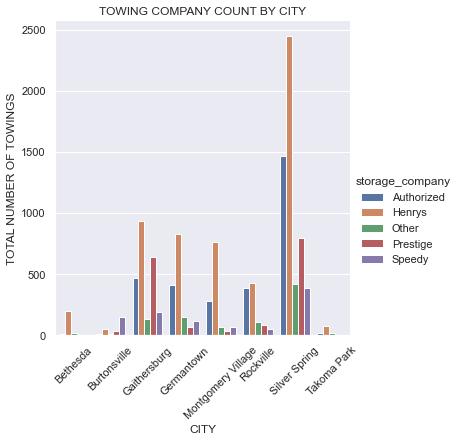

In [76]:
#Visualization of towing by company
sns.set(rc={'figure.figsize':(12.7,10.27)})
sns.catplot(x="city", y="count_col", hue="storage_company", kind="bar", data=df5)
plt.xticks(rotation=45)
plt.title("TOWING COMPANY COUNT BY CITY")
plt.xlabel("CITY")
plt.ylabel("TOTAL NUMBER OF TOWINGS")
plt.savefig('companyCITY.png')

plt.show()

In [77]:
#COMPARISON OF HOUSEHOLD INCOME BETWEEN CITIES; BOXPLOT FOR TOP 5.

In [78]:
#Create dataframe with demographics and geo only; has duplicate columns for demographics - DO NOT SUM DEMOGRAPHICS
tow_demo = pd.DataFrame(tow.drop(columns = ["tow_date", "tow_reason", "storage_company", "street", "longitude", "latitude", "location", "tract"]))
tow_demo["pop_white"] = tow_demo["pop_total"] - tow_demo["pop_black"]
print(tow_demo.head())
tow_demo.info()
print(len(tow_demo))
print("population sum here is from duplicated rows: ", sum(tow_demo["pop_total"]))

           city                  geo_location    block  hh_income  pop_total  \
0  Gaithersburg  POINT (-77.175624 39.211873)  7001012     208929       1931   
1  Gaithersburg  POINT (-77.167752 39.208712)  7001013     135208        800   
2  Gaithersburg  POINT (-77.148754 39.211605)  7001013     135208        800   
3  Gaithersburg  POINT (-77.141329 39.207148)  7001032     218173       1017   
4  Gaithersburg  POINT (-77.153158 39.166038)  7001033     172778       3112   

   pop_black  state                    geometry  pop_white  
0         39     24  POINT (39.21187 -77.17562)       1892  
1         10     24  POINT (39.20871 -77.16775)        790  
2         10     24  POINT (39.21160 -77.14875)        790  
3        193     24  POINT (39.20715 -77.14133)        824  
4        345     24  POINT (39.16604 -77.15316)       2767  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 19753 entries, 0 to 19974
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
-

block_grp population is 12855428
   hh_income  pop_total  pop_black  pop_white                  geo_location  \
0      22628       1048        327        721  POINT (-77.062826 39.091315)   
1      22628       1048        327        721  POINT (-77.062903 39.091326)   
2      22628       1048        327        721  POINT (-77.063028 39.091343)   
3      25636        966        576        390  POINT (-77.029994 38.997657)   
4      25636        966        576        390  POINT (-77.030226 38.997871)   

            city    block  count_col  
0  Silver Spring  7032201         62  
1  Silver Spring  7032201          1  
2  Silver Spring  7032201          1  
3  Silver Spring  7025003          1  
4  Silver Spring  7025003         26  
       block          city  hh_income  pop_total  pop_black  sum_col  \
0    7001012  Gaithersburg     208929       1931         39        1   
1    7001013  Gaithersburg     135208        800         10        2   
2    7001032  Gaithersburg     218173     

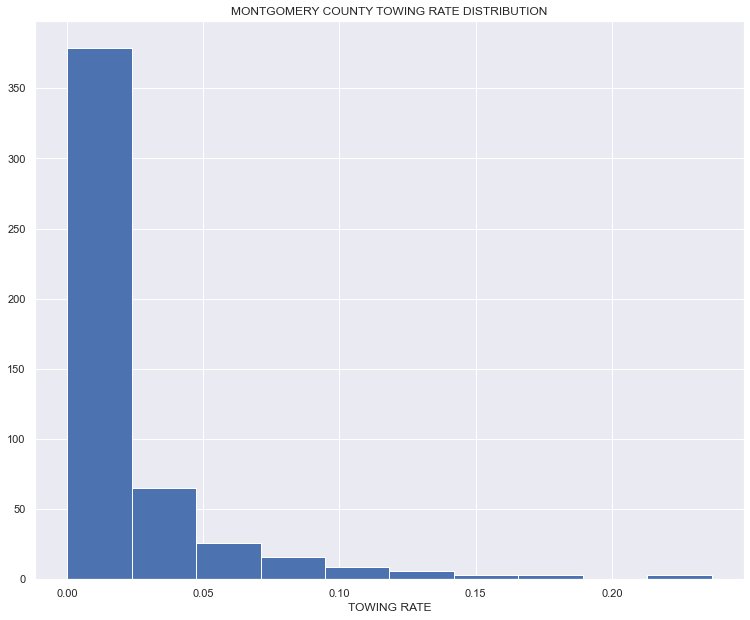

In [79]:
#CALCULATE TOW COUNTS, THEN SUMS BY BLOCK
block_grp = tow_demo.groupby(["hh_income", "pop_total", "pop_black", "pop_white", "geo_location", "city" , "block"]).agg(count_col=pd.NamedAgg(column="block", aggfunc="count"))
block_grp = block_grp.reset_index() #flatten level
print("block_grp population is", sum(block_grp["pop_total"]))
#put demo count by block in dataframe "citygrp_df1"
blockgrp_df = pd.DataFrame(block_grp) #contains counts by property within block (for maps)
print(blockgrp_df.head())
#USE BLOCKSUM TO COMPUTE IQR NEXT CHUNK
blocksum_grp = blockgrp_df.groupby(["block", "city", "hh_income", "pop_total", "pop_black"]).agg(sum_col=pd.NamedAgg(column="count_col", aggfunc="sum")) 
blocksum_grp = blocksum_grp.reset_index()
blocksum_df = pd.DataFrame(blocksum_grp)
blocksum_df
blocksum_df["tow_rate"] = blocksum_df["sum_col"] / blocksum_df["pop_total"]
blocksum_df["black_rate"] = blocksum_df["pop_black"] / blocksum_df["pop_total"]
print(blocksum_df)
print("blocksum_df population is", sum(blocksum_df["pop_total"])) #DO NOT SUM DEMOGRAPHICS IN DF - USE FOR RATE ONLY
plt.hist(x = blocksum_df["tow_rate"])
plt.title("MONTGOMERY COUNTY TOWING RATE DISTRIBUTION")
plt.xlabel("TOWING RATE")
plt.savefig('histo_tow.png')
plt.show()

In [80]:
#Calculate IQR and determine inner fences for outliers: ufence = upper fence and lfence = lower fence
print(blocksum_df.describe())   #to get input values
q1 = np.quantile(blocksum_df["tow_rate"], 0.25)
q3 = np.quantile(blocksum_df["tow_rate"], 0.75)
x = (q3 - q1)*1.5
mean_towrate = blocksum_df["tow_rate"].mean()
lfence = q1 - x
ufence = q3 + x
print("lower and upper fence values: ", lfence, ufence)
print("overall mean tow rate: ", mean_towrate)
#mean is .0207; upper fence is .0592

              block      hh_income    pop_total    pop_black     sum_col  \
count  5.100000e+02     510.000000   510.000000   510.000000  510.000000   
mean   7.019728e+06  115609.007843  1849.452941   387.092157   38.731373   
std    1.512828e+04   48836.053841   957.609177   393.658066   70.300900   
min    7.001012e+06   22628.000000   395.000000     0.000000    1.000000   
25%    7.008152e+06   80781.000000  1222.000000    99.500000    2.000000   
50%    7.014096e+06  106279.000000  1634.000000   263.000000   10.000000   
75%    7.032099e+06  141649.500000  2313.250000   514.250000   40.750000   
max    7.060123e+06  250001.000000  8987.000000  2051.000000  500.000000   

         tow_rate  black_rate  
count  510.000000  510.000000  
mean     0.020710    0.198729  
std      0.034281    0.171247  
min      0.000111    0.000000  
25%      0.001401    0.068987  
50%      0.005429    0.158811  
75%      0.024516    0.276669  
max      0.236559    0.933830  
lower and upper fence value

In [81]:
#Separate into 2 groups(dataframes) top5_demo for top 5 cities, and other_demo for all other cities as a group
#This gives us two independent groups for statistical testing
top5_demo = blocksum_df.loc[blocksum_df['city'].isin(city_list5)]
other_demo = blocksum_df.loc[~blocksum_df['city'].isin(city_list5)]
print(top5_demo.info())
print(top5_demo)
print(top5_demo.describe())
print(other_demo.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318 entries, 0 to 456
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   block       318 non-null    int64  
 1   city        318 non-null    object 
 2   hh_income   318 non-null    int64  
 3   pop_total   318 non-null    int64  
 4   pop_black   318 non-null    int64  
 5   sum_col     318 non-null    int64  
 6   tow_rate    318 non-null    float64
 7   black_rate  318 non-null    float64
dtypes: float64(2), int64(5), object(1)
memory usage: 22.4+ KB
None
       block           city  hh_income  pop_total  pop_black  sum_col  \
0    7001012   Gaithersburg     208929       1931         39        1   
1    7001013   Gaithersburg     135208        800         10        2   
2    7001032   Gaithersburg     218173       1017        193        1   
4    7001033   Gaithersburg     172778       3112        345        6   
5    7001041   Gaithersburg     118906       2619    

In [82]:
#Separate into 2 groups(dataframes) top5_demo for top 5 cities, and other_demo for all other cities as a group
#This gives us two independent groups for statistical testing
top5_box = blocksum_df.loc[blocksum_df['city'].isin(city_list5)]
other_box = blocksum_df.loc[~blocksum_df['city'].isin(city_list5)]
print(top5_box.info())
print(top5_box)
print(top5_box.describe())
print(other_box.describe())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 318 entries, 0 to 456
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   block       318 non-null    int64  
 1   city        318 non-null    object 
 2   hh_income   318 non-null    int64  
 3   pop_total   318 non-null    int64  
 4   pop_black   318 non-null    int64  
 5   sum_col     318 non-null    int64  
 6   tow_rate    318 non-null    float64
 7   black_rate  318 non-null    float64
dtypes: float64(2), int64(5), object(1)
memory usage: 22.4+ KB
None
       block           city  hh_income  pop_total  pop_black  sum_col  \
0    7001012   Gaithersburg     208929       1931         39        1   
1    7001013   Gaithersburg     135208        800         10        2   
2    7001032   Gaithersburg     218173       1017        193        1   
4    7001033   Gaithersburg     172778       3112        345        6   
5    7001041   Gaithersburg     118906       2619    

In [83]:
print(len(blocksum_df))
print(len(top5_box))
print(len(other_box))
#510 > total census blocks because some blocks straddle to city names


510
318
192


<function matplotlib.pyplot.show(close=None, block=None)>

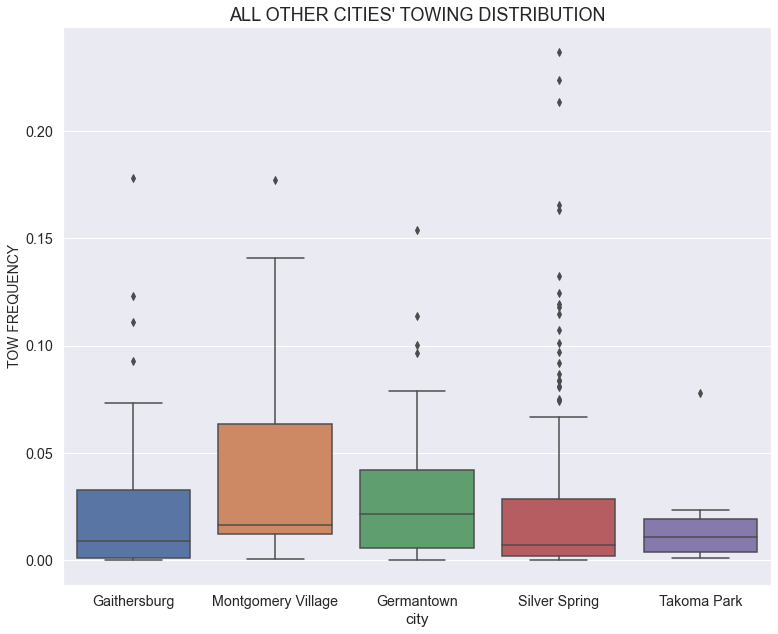

In [84]:
#Show distribution of tow rate for top 5 actively towed cities
sns.set(font_scale=1.3)
sns.boxplot(x = "city", y = "tow_rate", data = top5_box)
plt.title("ALL OTHER CITIES' TOWING DISTRIBUTION", fontsize=18)
plt.ylabel("TOW FREQUENCY", fontsize=14)
plt.savefig('top5_boxplot.png')
plt.show
#Outliers here are important, because they all represent a block(and thus hh_income level) that are towed at higher
#rates than what the expected distribution would indicate


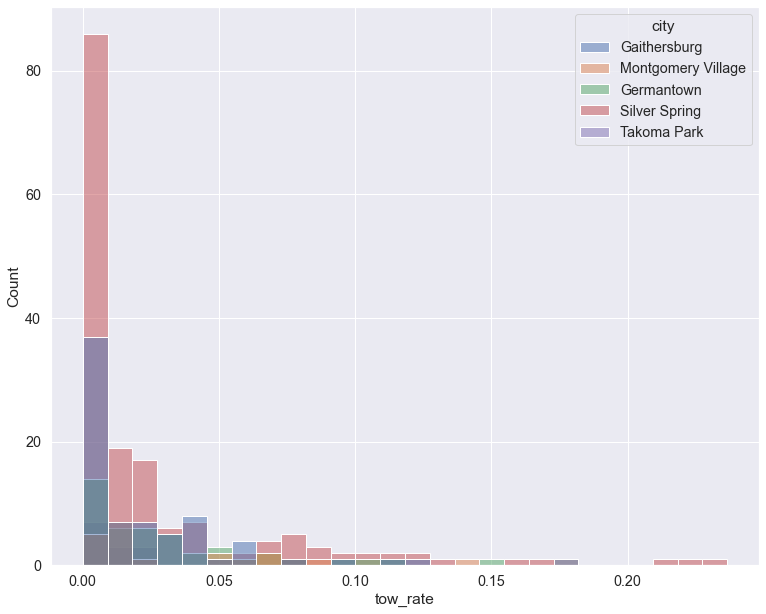

In [85]:
#plot top 5 cities using block data
sns.histplot(x = "tow_rate", hue = "city", data = top5_box)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

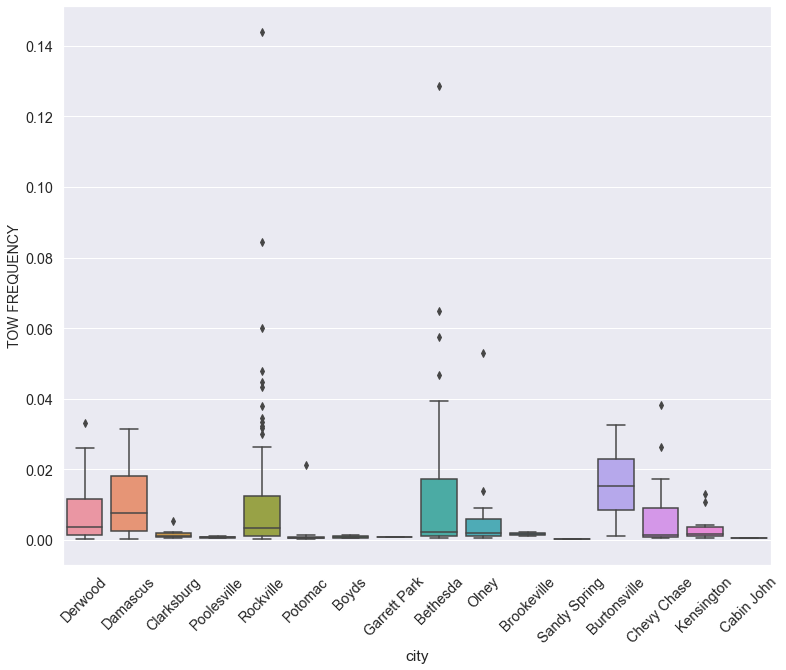

In [86]:
#Show distribution of tow rate for other cities
sns.set(font_scale=1.3)
sns.boxplot(x = "city", y = "tow_rate", data = other_box)
plt.xticks(rotation=45)
#plt.title("ALL OTHER CITIES", fontsize=18)
plt.ylabel("TOW FREQUENCY", fontsize=14)
plt.savefig('other_boxplot.png')
plt.show


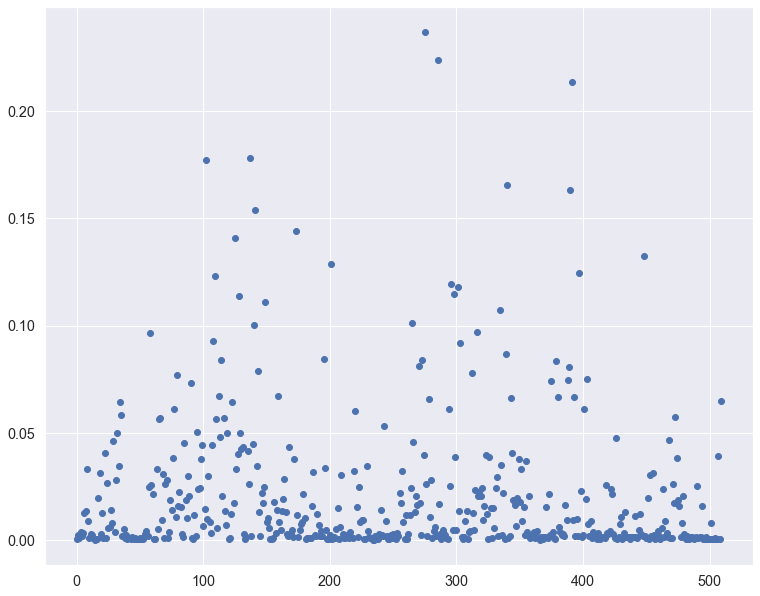

       block                city  hh_income  pop_total  pop_black  sum_col  \
102  7007212  Montgomery Village      56188       1921        197      340   
109  7007233        Gaithersburg      82083        860        179      106   
125  7008134  Montgomery Village      54931       2201        626      310   
128  7008153          Germantown      63659        395         86       45   
137  7008172        Gaithersburg      90385       1854        198      330   
140  7008181          Germantown      47472       1266        579      127   
141  7008182          Germantown      62000       2043        459      314   
149  7008221        Gaithersburg      80781       1886        264      209   
173  7009041           Rockville      76630       1834        375      264   
201  7012053            Bethesda     124554        762         33       98   
265  7014172       Silver Spring      67109       1491       1071      151   
275  7014222       Silver Spring      52768       1209       112

In [87]:
#Find outliers using Generalized Extreme Test for Outliers (Grubb/Rosner), may not be accurate as it requires
#approximate normality (as well as n>=25); our population is not normal
#This test gives us a cutoff values for extreme outliers which are usually wider than the
#IQR calculations.  Test on all cities.
#CODE SOURCE CREDIT to: https://github.com/bhattbhavesh91/outlier-detection-grubbs-test-and-generalized-esd-test-python
#first create array to create scatterplot all tow_rate points in citygrp_df(all cities)
y = np.array(blocksum_df["tow_rate"])
x = np.arange(len(y))
plt.scatter(x,y)
plt.show()
print(blocksum_df[blocksum_df["tow_rate"] > .10])

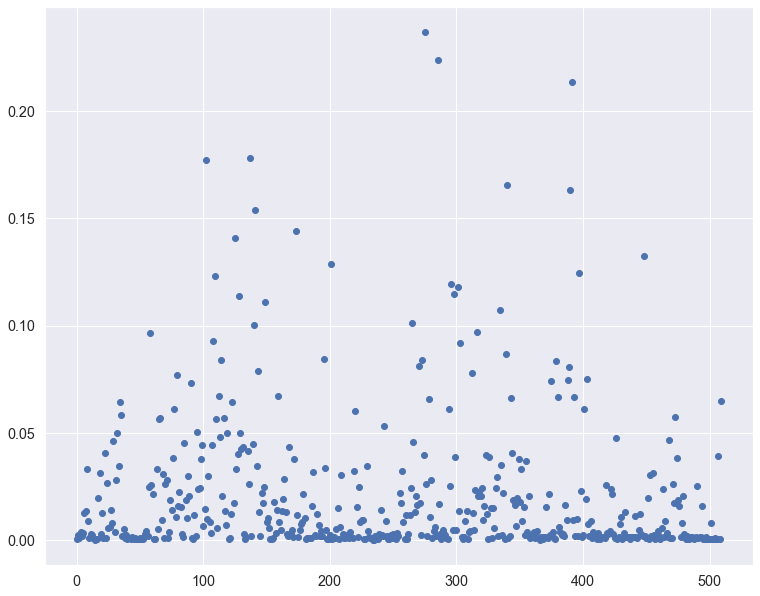

In [88]:
#enter a (y,x) from above; requires 2 points for code below
y[275] = 0.236559
y[201] = 0.128609
plt.scatter(x,y)

In [89]:
def grubbs_stat(y):
    std_dev = np.std(y)
    avg_y = np.mean(y)
    abs_val_minus_avg = abs(y - avg_y)
    max_of_deviations = max(abs_val_minus_avg)
    max_ind = np.argmax(abs_val_minus_avg)
    Gcal = max_of_deviations/ std_dev
    print("Grubbs Statistics Value : {}".format(Gcal))
    return Gcal, max_ind

In [90]:
def calculate_critical_value(size, alpha):
    t_dist = stats.t.ppf(1 - alpha / (2 * size), size - 2)
    numerator = (size - 1) * np.sqrt(np.square(t_dist))
    denominator = np.sqrt(size) * np.sqrt(size - 2 + np.square(t_dist))
    critical_value = numerator / denominator
    print("Grubbs Critical Value: {}".format(critical_value))
    return critical_value

In [91]:
def check_G_values(Gs, Gc, inp, max_index):
    if Gs > Gc:
        print('{} is an outlier. G > G-critical: {:.4f} > {:.4f} \n'.format(inp[max_index], Gs, Gc))
    else:
        print('{} is not an outlier. G > G-critical: {:.4f} > {:.4f} \n'.format(inp[max_index], Gs, Gc))

In [92]:
def ESD_Test(input_series, alpha, max_outliers):
    for iterations in range(max_outliers):
        Gcritical = calculate_critical_value(len(input_series), alpha)
        Gstat, max_index = grubbs_stat(input_series)
        check_G_values(Gstat, Gcritical, input_series, max_index)
        input_series = np.delete(input_series, max_index)

In [93]:
ESD_Test(y, 0.05, 30)
#RESULT SHOWS MIN OF .0919 FOR CLASSIFICATION AS OUTLIER CUTOFF

Grubbs Critical Value: 3.8683628857247316
Grubbs Statistics Value : 6.3026342710819065
0.236559 is an outlier. G > G-critical: 6.3026 > 3.8684 

Grubbs Critical Value: 3.8678444751846253
Grubbs Statistics Value : 6.183211484061652
0.22381378692927484 is an outlier. G > G-critical: 6.1832 > 3.8678 

Grubbs Critical Value: 3.8673249277101394
Grubbs Statistics Value : 6.108511249083501
0.21343028229255775 is an outlier. G > G-critical: 6.1085 > 3.8673 

Grubbs Critical Value: 3.8668042384778607
Grubbs Statistics Value : 5.19191593100683
0.1779935275080906 is an outlier. G > G-critical: 5.1919 > 3.8668 

Grubbs Critical Value: 3.8662824026344946
Grubbs Statistics Value : 5.307548163388083
0.17699115044247787 is an outlier. G > G-critical: 5.3075 > 3.8663 

Grubbs Critical Value: 3.8657594152958583
Grubbs Statistics Value : 5.076104490074053
0.16567291311754684 is an outlier. G > G-critical: 5.0761 > 3.8658 

Grubbs Critical Value: 3.8652352715464118
Grubbs Statistics Value : 5.134260608778

In [94]:
#Initialize GESD variable extreme_cutoff
extreme_cutoff = 0.0919

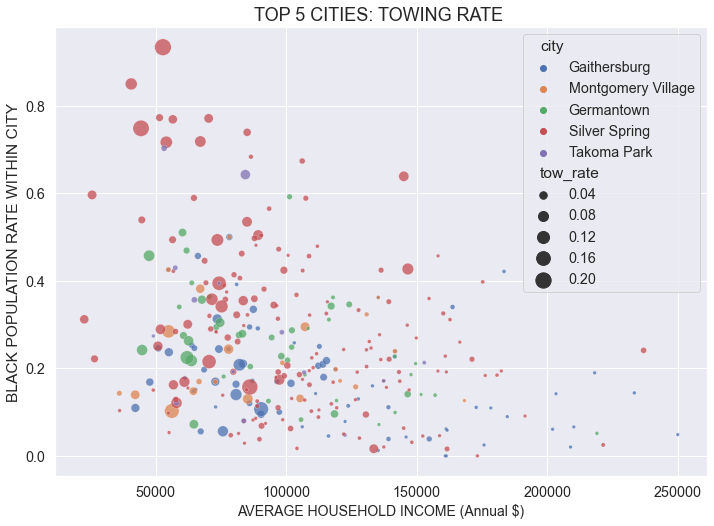

In [95]:
#Set figure size to enlarge for clearer view
sns.set(rc={'figure.figsize':(11.7,8.27)})
#scatterplot(set sizes of tow_rate bubbles)
sns.set(font_scale=1.3)
sns.scatterplot(x='hh_income', y='black_rate', hue = "city", size = "tow_rate", data=top5_box, sizes=(12, 275), alpha=.75)
plt.title("TOP 5 CITIES: TOWING RATE ", fontsize=18)
plt.xlabel("AVERAGE HOUSEHOLD INCOME (Annual $)", fontsize=14)
plt.ylabel("BLACK POPULATION RATE WITHIN CITY")
plt.savefig('bubble_TOP5.png')
plt.show()
#WE CAN CLEARLY SEE THAT THE LOWER INCOME TOWINGS (RATE = COUNT/CITY POPULATION) APPEAR EXCESSIVE FOR TOP 5 TOWED CITIES
#WE CAN ALSO SEE THE LOWEST INCOME RATES EXPERIENCING EXCESSIVE TOWING ARE AS HIGH AS 80% BLACK POPULATIONS

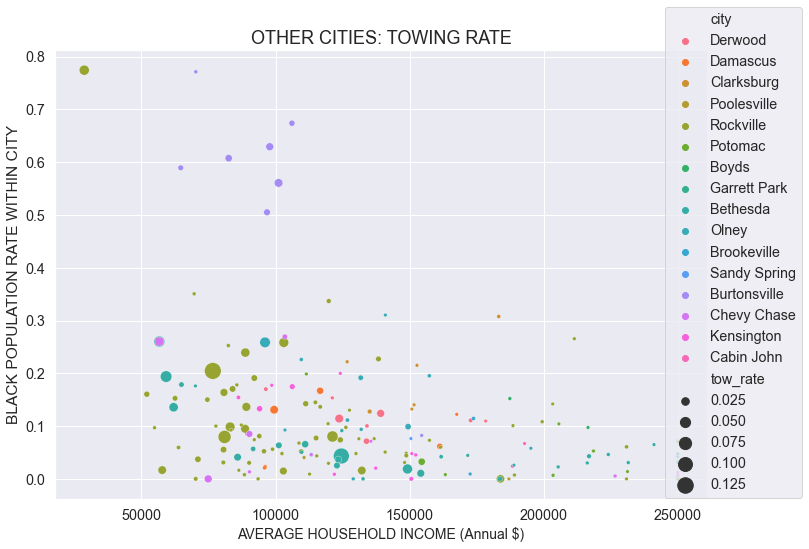

In [96]:
#Set figure size to enlarge for clearer view
sns.set(rc={'figure.figsize':(11.7,8.27)})
#scatterplot(set sizes of tow_rate bubbles)
sns.set(font_scale=1.3)
sns.scatterplot(x='hh_income', y='black_rate', hue = "city", size = "tow_rate", data=other_box, sizes=(12, 275))
plt.title("OTHER CITIES: TOWING RATE", fontsize=18)
plt.xlabel("AVERAGE HOUSEHOLD INCOME (Annual $)", fontsize=14)
plt.ylabel("BLACK POPULATION RATE WITHIN CITY")
plt.legend(bbox_to_anchor=(1,1), loc=2, borderaxespad=-3.)
plt.savefig('bubble_OTHER.png')
plt.show()
#WE CAN CLEARLY SEE THAT THE LOWER INCOME TOWINGS (RATE = COUNT/CITY POPULATION) APPEAR EXCESSIVE FOR TOP 5 TOWED CITIES
#WE CAN ALSO SEE THE LOWEST INCOME RATES EXPERIENCING EXCESSIVE TOWING ARE AS HIGH AS 80% BLACK POPULATIONS

In [97]:
#Kruskal-Wallis H-test; non-parametric analysis of variance: H-0: medians are the same vs H_alpha
# with alpha = .05: the medians differ
x = top5_demo["tow_rate"]
y = other_demo["tow_rate"]
stats.kruskal(x, y)
#Result suggests we can very strongly reject the null hypothesis that the medians are the same; seems to agree
#with boxplot view

KruskalResult(statistic=43.89127263156833, pvalue=3.471332970261465e-11)

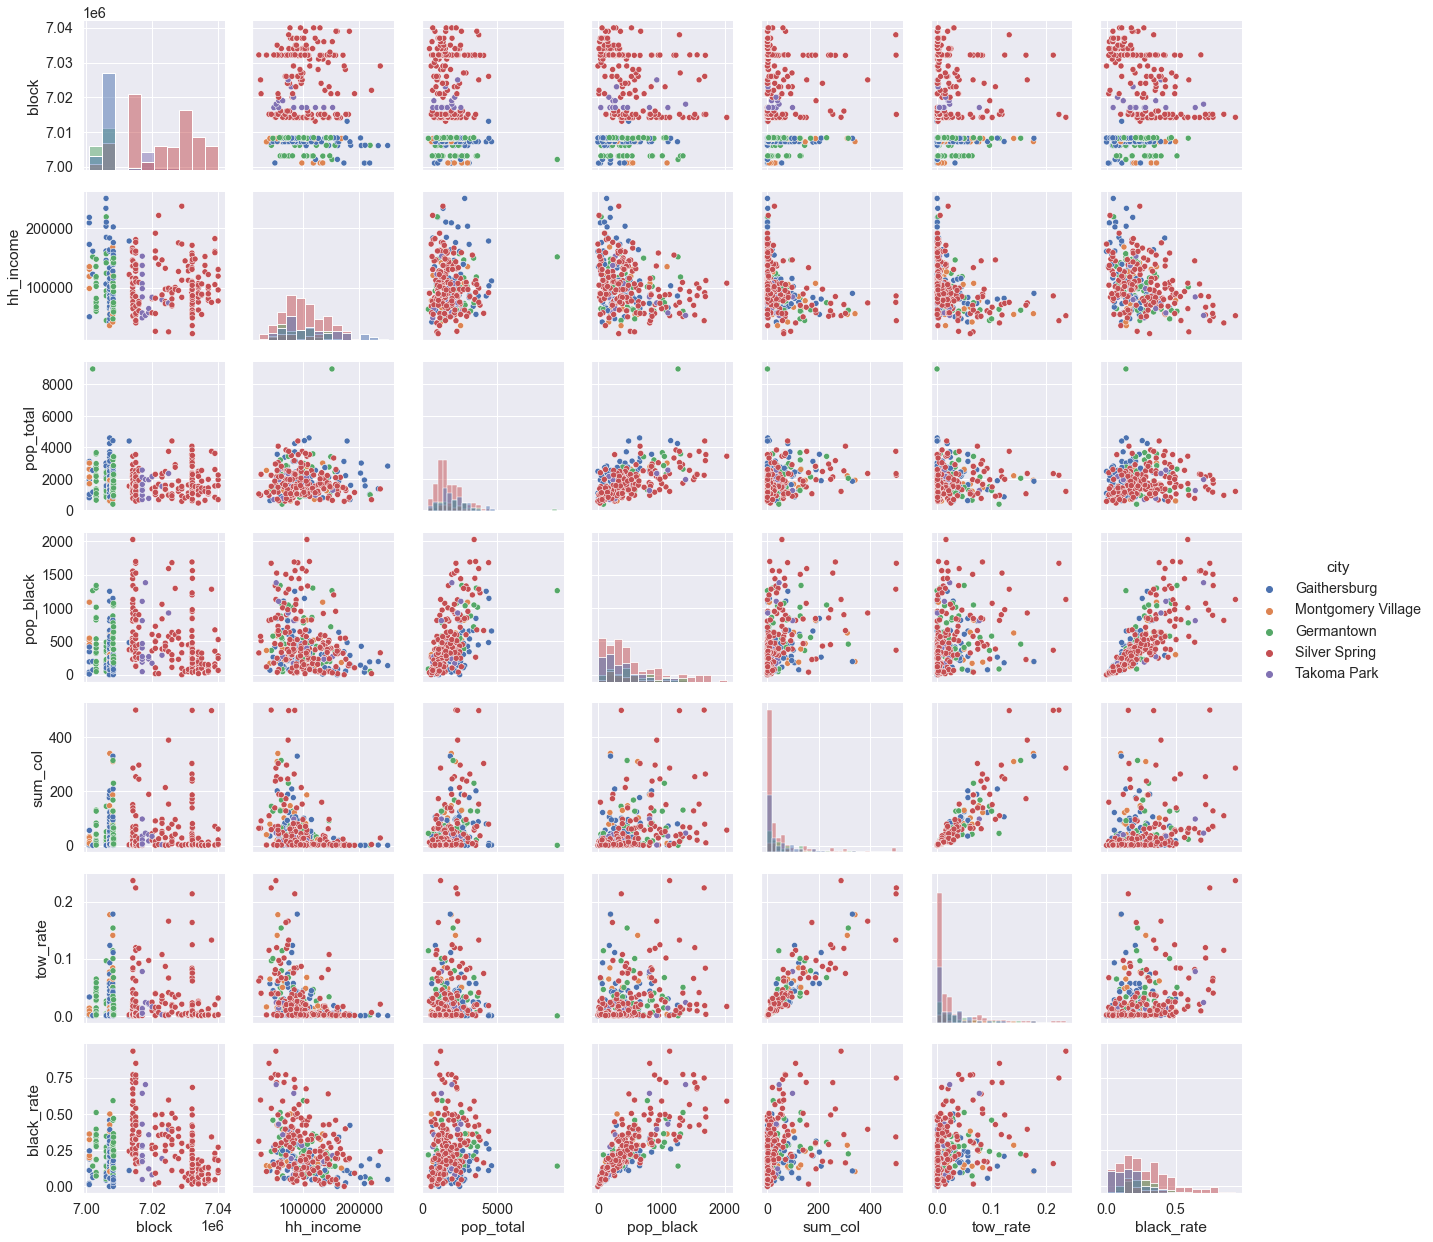

In [98]:
#look at correlations between pairs of variables
g = sns.PairGrid(top5_box, hue="city")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
#population totals and breakdowns have linear correlation as would be expected
#black rate seems to show high tow rates in some areas even in upper incomes; white_rate seems to have a cutoff
#where whites of a certain income no longer experience towing at all

In [99]:
#Independent dataframes by city for block/individual property drilldown on demographics
btc = blocksum_df[blocksum_df['city']=="Bethesda"]
btb = blocksum_df[blocksum_df['city']=="Burtonsville"]
gbc = blocksum_df[blocksum_df['city']=="Gaithersburg"]
gtc = blocksum_df[blocksum_df['city']=="Germantown"]
mvc = blocksum_df[blocksum_df['city']=="Montgomery Village"]
rvc = blocksum_df[blocksum_df['city']=="Rockville"]
ssc = blocksum_df[blocksum_df['city']=="Silver Spring"]
tpc = blocksum_df[blocksum_df["city"]=="Takoma Park"]
print(sum(ssc["tow_rate"]))
print(len(gbc) + len(gtc) + len(tpc) + len(mvc) + len(ssc))
print(gbc)
print(gbc[gbc["tow_rate"] > .06])

4.389748420500894
318
       block          city  hh_income  pop_total  pop_black  sum_col  \
0    7001012  Gaithersburg     208929       1931         39        1   
1    7001013  Gaithersburg     135208        800         10        2   
2    7001032  Gaithersburg     218173       1017        193        1   
4    7001033  Gaithersburg     172778       3112        345        6   
5    7001041  Gaithersburg     118906       2619        518        9   
..       ...           ...        ...        ...        ...      ...   
155  7008281  Gaithersburg     175787       2209         55        2   
156  7008291  Gaithersburg     154792       1500         58       27   
157  7008292  Gaithersburg     116193       1762         80        6   
160  7008331  Gaithersburg     141597       1678        381       14   
235  7013071  Gaithersburg     178365       4409        483        1   

     tow_rate  black_rate  
0    0.000518    0.020197  
1    0.002500    0.012500  
2    0.000983    0.189774  
4

In [100]:
#HEATMAPS OF TOP 5 CITIES' by individual properties within each block SHOW PROBLEM AREAS

gtc.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '10px'})

,block,city,hh_income,pop_total,pop_black,sum_col,tow_rate,black_rate
14,7002051,Germantown,151683,8987,1261,1,0.000111,0.140314
22,7003041,Germantown,117222,941,322,38,0.040383,0.342189
23,7003043,Germantown,135530,2251,161,2,0.000888,0.071524
24,7003044,Germantown,73226,2792,822,75,0.026862,0.294413
25,7003062,Germantown,117929,3591,1300,21,0.005848,0.362016
26,7003063,Germantown,116361,2762,860,17,0.006155,0.311369
27,7003081,Germantown,63819,1361,538,19,0.013960,0.395298
28,7003082,Germantown,76016,1854,336,15,0.008091,0.181230
29,7003083,Germantown,118487,887,85,41,0.046223,0.095829
30,7003084,Germantown,107176,2165,401,8,0.003695,0.185219


In [101]:
gbc.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '10px'})

,block,city,hh_income,pop_total,pop_black,sum_col,tow_rate,black_rate
0,7001012,Gaithersburg,208929,1931,39,1,0.000518,0.020197
1,7001013,Gaithersburg,135208,800,10,2,0.002500,0.012500
2,7001032,Gaithersburg,218173,1017,193,1,0.000983,0.189774
4,7001033,Gaithersburg,172778,3112,345,6,0.001928,0.110861
5,7001041,Gaithersburg,118906,2619,518,9,0.003436,0.197785
8,7001051,Gaithersburg,50977,1693,416,56,0.033077,0.245718
10,7001053,Gaithersburg,135263,3006,1088,3,0.000998,0.361943
16,7002063,Gaithersburg,122560,2546,200,1,0.000393,0.078555
21,7002082,Gaithersburg,161250,1168,72,1,0.000856,0.061644
44,7006044,Gaithersburg,233362,1376,198,2,0.001453,0.143895


In [102]:
mvc.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '10px'})

,block,city,hh_income,pop_total,pop_black,sum_col,tow_rate,black_rate
6,7001041,Montgomery Village,118906,2619,518,33,0.012600,0.197785
7,7001042,Montgomery Village,98558,2125,452,29,0.013647,0.212706
9,7001052,Montgomery Village,130833,1698,549,15,0.008834,0.323322
11,7001053,Montgomery Village,135263,3006,1088,8,0.002661,0.361943
77,7007131,Montgomery Village,67071,1668,637,102,0.061151,0.381894
79,7007132,Montgomery Village,77917,1915,467,147,0.076762,0.243864
80,7007133,Montgomery Village,36071,2545,364,40,0.015717,0.143026
101,7007211,Montgomery Village,54861,1375,585,20,0.014545,0.425455
102,7007212,Montgomery Village,56188,1921,197,340,0.176991,0.102551
105,7007222,Montgomery Village,78214,602,301,5,0.008306,0.500000


In [103]:
tpc.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '10px'})

,block,city,hh_income,pop_total,pop_black,sum_col,tow_rate,black_rate
306,7017011,Takoma Park,49107,690,189,1,0.001449,0.273913
307,7017012,Takoma Park,106875,2104,401,19,0.009030,0.190589
308,7017021,Takoma Park,57500,2562,1101,35,0.013661,0.429742
310,7017031,Takoma Park,137330,1360,233,5,0.003676,0.171324
311,7017032,Takoma Park,122500,967,46,4,0.004137,0.047570
312,7017033,Takoma Park,84353,1262,811,98,0.077655,0.642631
313,7017041,Takoma Park,98333,1653,467,21,0.012704,0.282517
314,7017042,Takoma Park,152875,1282,273,6,0.004680,0.212949
315,7018001,Takoma Park,53224,1963,1380,46,0.023434,0.703006
317,7019001,Takoma Park,57973,1950,236,40,0.020513,0.121026


In [104]:
ssc.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '10px'})



,block,city,hh_income,pop_total,pop_black,sum_col,tow_rate,black_rate
236,7013081,Silver Spring,122014,1543,375,3,0.001944,0.243033
249,7014071,Silver Spring,166500,2104,547,2,0.000951,0.259981
250,7014073,Silver Spring,136250,2172,478,6,0.002762,0.220074
252,7014083,Silver Spring,115785,1406,495,1,0.000711,0.352063
253,7014091,Silver Spring,162750,1166,363,4,0.003431,0.311321
254,7014092,Silver Spring,146369,1728,516,3,0.001736,0.298611
258,7014141,Silver Spring,160167,1315,428,11,0.008365,0.325475
259,7014143,Silver Spring,88421,2336,1124,1,0.000428,0.481164
260,7014144,Silver Spring,93472,2549,1440,30,0.011769,0.564927
261,7014152,Silver Spring,100739,1759,806,1,0.000569,0.458215


In [105]:
#TEST IF INCOME IN PAIRED CITIES HAVE THE SAME DISTRIBUTION OR ARE DIFFERENT: Use Mann Whitney U Test
#H_0: THEY HAVE THE SAME DISTRIBUTIONS
#H_alpha: THEY HAVE DIFFERENT DISTRIBUTIONS
#alpha = 0.05

#FOR GERMANTOWN: Montgomery Village, alpha > 0.05; cannot reject the null 
#FOR GERMANTOWN: Gaithersburg, , Takoma Park, Silver Spring, alpha < 0.05; reject the null

In [106]:
#Shapiro_wilk test for normality: H_0: data is distributed normally; H_alpha: data is not normally distributed
data = pd.Series(top5_demo["tow_rate"])
print(shapiro(data))
#reject the null; for alpha <0.05, this very strongly suggests tow_rate is not normally distributed; t-test 
#and chi_square testing for independence will not be appropriate; use Mann-Whitney U Test

data = pd.Series(other_demo["tow_rate"])
print(shapiro(data))
#same
data = pd.Series(blocksum_df["tow_rate"])
print(shapiro(data))
#same
#all p<=alpha = 0.05; strongly reject the null

ShapiroResult(statistic=0.6853362321853638, pvalue=6.191928989413029e-24)
ShapiroResult(statistic=0.5503930449485779, pvalue=5.071814204042078e-22)
ShapiroResult(statistic=0.6240696907043457, pvalue=7.364935252675855e-32)


In [107]:
#Mann Whitney U Test:  GERMANTOWN
import scipy.stats
from scipy.stats import mannwhitneyu
scipy.stats.mannwhitneyu(gbc["tow_rate"], gtc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=1209.0, pvalue=0.00992940244930318)

In [108]:
scipy.stats.mannwhitneyu(mvc["tow_rate"], gtc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=435.0, pvalue=0.2547179195727841)

In [109]:
scipy.stats.mannwhitneyu(tpc["tow_rate"], gtc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=206.0, pvalue=0.03256701365644925)

In [110]:
scipy.stats.mannwhitneyu(ssc["tow_rate"], gtc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=2700.0, pvalue=0.005235736244517493)

In [111]:
#Mann Whitney U Test ; GAITHERSBURG 

#For Gaithersburg:  Silver Spring, Takoma Park, Germantown, alpha > 0.05; cannot reject the null 
#For Gaithersburg:   Montgomery Village; reject the null
scipy.stats.mannwhitneyu(mvc["tow_rate"], gbc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=522.0, pvalue=0.005525737109465313)

In [112]:
scipy.stats.mannwhitneyu(tpc["tow_rate"], gbc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=510.0, pvalue=0.4659076107689019)

In [113]:
scipy.stats.mannwhitneyu(ssc["tow_rate"], gbc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=5808.5, pvalue=0.2991628380829954)

In [114]:
#Mann Whitney U Test ; MONTGOMERY VILLAGE
#For Montgomery Village:   Germantown, alpha > 0.05; cannot reject the null 
#For Montgomery Village:  Gaithersburg, Takoma Park, Silver Spring.    reject the null
scipy.stats.mannwhitneyu(tpc["tow_rate"], mvc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=98.0, pvalue=0.035853507751215395)

In [115]:
scipy.stats.mannwhitneyu(ssc["tow_rate"], mvc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=1203.0, pvalue=0.0056625887737787395)

In [116]:
#Mann Whitney U Test ; TAKOMA PARK
#For Takoma Park:  Gaithersburg, Silver Spring,; alpha > 0.05; cannot reject the null 
#For Takoma Park: Montgomery Village,  Germantown;    reject the null
scipy.stats.mannwhitneyu(ssc["tow_rate"], tpc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=1130.5, pvalue=0.46340454310405144)

In [117]:
#Mann Whitney U Test ; SILVER SPRING
#For Silver Spring:  Gaithersburg, Takoma Park, ,  alpha > 0.05; cannot reject the null 
#For Silver Spring: Montgomery Village, Germantown;    reject the null

In [118]:
#Mann Whitney U Test on Top5 as a whole, against all other cities as a whole
scipy.stats.mannwhitneyu(top5_demo["tow_rate"], other_demo["tow_rate"], use_continuity = True, alternative=None)
#Very strongly reject the null that Top5 as a whole and Other cities as a whole share the same distribution. 

MannwhitneyuResult(statistic=19845.5, pvalue=1.7393138034526993e-11)

In [119]:
#get total number of tows and population for each group for Chi-Square in next chunk
print(top5_demo.describe())
print(other_demo.describe())
n_top5 = len(top5_demo)
n_other = len(other_demo)
print(n_top5, n_other)
pop_top5 = sum(top5_box["pop_total"]) #need to use grouped df here; cannot sum populations in top5_demo
pop_other = sum(other_box["pop_total"]) #need to use grouped df here; cannot sum populations in other_demo
print(pop_top5, pop_other)

              block      hh_income    pop_total    pop_black     sum_col  \
count  3.180000e+02     318.000000   318.000000   318.000000  318.000000   
mean   7.016920e+06  104219.512579  1866.877358   473.707547   51.044025   
std    1.137665e+04   41347.111455   920.582788   392.778350   82.354803   
min    7.001012e+06   22628.000000   395.000000     0.000000    1.000000   
25%    7.007222e+06   73594.000000  1242.750000   197.250000    3.000000   
50%    7.014204e+06   97378.500000  1664.000000   369.000000   18.500000   
75%    7.028002e+06  131583.000000  2341.750000   632.000000   62.750000   
max    7.040004e+06  250001.000000  8987.000000  2028.000000  500.000000   

         tow_rate  black_rate  
count  318.000000  318.000000  
mean     0.026948    0.249652  
std      0.039507    0.170415  
min      0.000111    0.000000  
25%      0.002041    0.127749  
50%      0.011485    0.212827  
75%      0.034207    0.341296  
max      0.236559    0.933830  
              block      hh

In [120]:
#PERFORM PEARSON CHI-SQUARE FOR INDEPENDENCE (Mann-Whitney U non-parametric would be better for these two groups)
# defining the table
data = [[n_top5, n_other], [pop_top5, pop_other]]
chi2_contingency(data)
#Returns chi_squared value = 0.05233, p=0.819  #NOT VALID - not a Normal Distribution

(0.052331001307883145,
 0.8190556893221025,
 1,
 array([[3.20994383e+02, 1.89005617e+02],
        [5.93664006e+05, 3.49556994e+05]]))

In [121]:
#Perform t-test to compare means of each group: large n, independent; not useful here, because we know the actual means of the two groups
from scipy.stats import ttest_ind_from_stats
ttest_ind_from_stats(mean1=0.026948, std1=np.sqrt(0.039507), nobs1=n_top5,
                     mean2=0.010377, std2=np.sqrt(0.019215), nobs2=n_other)
#alpha <0.05; cannot reject null H_0: u_top5 = u_other
#The means may not be different between the top 5 cities as a group compared against all others as a group.  
#NOT VALID: not a normal distribution


Ttest_indResult(statistic=1.0155130030636468, pvalue=0.3103447618900968)

In [122]:
#now examine block groups which all have an average household income associated with each block

In [126]:
#put demo count by city in dataframe "block_df"; block and geo_code with highest volume;
block_df = blockgrp_df[["block", "count_col", "geo_location"]].copy()
block_df = block_df.sort_values(["block", "count_col"], ascending = (True, False))
block_df = block_df.reset_index()
#drop duplicate blocks to have one geo_code for markers at most towed property within block
block_df = block_df.drop_duplicates(subset="block", keep="first")
block_df = block_df.reset_index()
print(block_df.tail())
block_df.info()



     level_0  index    block  count_col                  geo_location
465     5848   5855  7060083          1  POINT (-77.226526 38.996884)
466     5849   4581  7060101          1  POINT (-77.159447 39.031472)
467     5850   1082  7060121         17  POINT (-77.153453 39.027533)
468     5864   1616  7060122          1  POINT (-77.150306 39.023799)
469     5865    834  7060123         14  POINT (-77.149295 39.024606)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   level_0       470 non-null    int64 
 1   index         470 non-null    int64 
 2   block         470 non-null    int64 
 3   count_col     470 non-null    int64 
 4   geo_location  470 non-null    object
dtypes: int64(4), object(1)
memory usage: 18.5+ KB


In [127]:
maps_df = blocksum_df.merge(block_df, how = "inner", on = "block")
maps_df

,block,city,hh_income,pop_total,pop_black,sum_col,tow_rate,black_rate,level_0,index,count_col,geo_location
0,7001012,Gaithersburg,208929,1931,39,1,0.000518,0.020197,0,5828,1,POINT (-77.175624 39.211873)
1,7001013,Gaithersburg,135208,800,10,2,0.002500,0.012500,1,5235,1,POINT (-77.148754 39.211605)
2,7001032,Gaithersburg,218173,1017,193,1,0.000983,0.189774,3,5839,1,POINT (-77.141329 39.207148)
3,7001033,Derwood,172778,3112,345,12,0.003856,0.110861,4,5766,2,POINT (-77.144806 39.147649)
4,7001033,Gaithersburg,172778,3112,345,6,0.001928,0.110861,4,5766,2,POINT (-77.144806 39.147649)
...,...,...,...,...,...,...,...,...,...,...,...,...
505,7060083,Potomac,231250,2594,36,1,0.000386,0.013878,5848,5855,1,POINT (-77.226526 38.996884)
506,7060101,Potomac,111500,1903,378,1,0.000525,0.198634,5849,4581,1,POINT (-77.159447 39.031472)
507,7060121,Bethesda,62000,892,121,35,0.039238,0.135650,5850,1082,17,POINT (-77.153453 39.027533)
508,7060122,Bethesda,70132,1335,235,1,0.000749,0.176030,5864,1616,1,POINT (-77.150306 39.023799)


In [128]:
#Tow rates over GESD outlier versus ufence
print("These blocks have tow rates >= GESD = 9.19%:  ")
print(maps_df[maps_df["tow_rate"] >= extreme_cutoff])
print("These blocks have tow rates >= ufence = 0.0554 ")
print(maps_df[maps_df["tow_rate"] >= ufence])
ufence

These blocks have tow rates >= GESD = 9.19%:  
       block                city  hh_income  pop_total  pop_black  sum_col  \
58   7006141          Germantown      44784       1505        364      145   
102  7007212  Montgomery Village      56188       1921        197      340   
108  7007232        Gaithersburg      75750       1315         74      122   
109  7007233        Gaithersburg      82083        860        179      106   
125  7008134  Montgomery Village      54931       2201        626      310   
128  7008153          Germantown      63659        395         86       45   
137  7008172        Gaithersburg      90385       1854        198      330   
140  7008181          Germantown      47472       1266        579      127   
141  7008182          Germantown      62000       2043        459      314   
149  7008221        Gaithersburg      80781       1886        264      209   
173  7009041           Rockville      76630       1834        375      264   
201  7012053     

0.059188152633806286

In [129]:
#May want to look at >=upper fence by looking at the GESD---> .0919 rounded
print("These blocks have tow rates >= 0.0919%  ")
print(blocksum_df[blocksum_df["tow_rate"] >= extreme_cutoff])


These blocks have tow rates >= 0.0919%  
       block                city  hh_income  pop_total  pop_black  sum_col  \
58   7006141          Germantown      44784       1505        364      145   
102  7007212  Montgomery Village      56188       1921        197      340   
108  7007232        Gaithersburg      75750       1315         74      122   
109  7007233        Gaithersburg      82083        860        179      106   
125  7008134  Montgomery Village      54931       2201        626      310   
128  7008153          Germantown      63659        395         86       45   
137  7008172        Gaithersburg      90385       1854        198      330   
140  7008181          Germantown      47472       1266        579      127   
141  7008182          Germantown      62000       2043        459      314   
149  7008221        Gaithersburg      80781       1886        264      209   
173  7009041           Rockville      76630       1834        375      264   
201  7012053           

In [130]:
#INVESTIGATE NEIGHBORHOODS WITH TOW RATES >=15%; just to see soe og the worst
#7015051 block is The Enclave Apartments at 11225 Oak Leaf Dr, Silver Spring
#7032141 block is Cinnamon Run at Peppertree Farms, 14120 Weeping Willow Dr, Aspen Hill?, not SS?
#7014222 block is Woodvale Apartments, 13831 Castle Blvd., Silver Spring, MD, Windsor Court and Tower Apartments,
#13802 Castle Blvd
#7008182 is The Colony Apartments in Germantown
#7008172 is

print("These blocks have tow rates >= upper fence  ")
print(blocksum_df[blocksum_df["tow_rate"] >= ufence])



These blocks have tow rates >= upper fence  
       block                city  hh_income  pop_total  pop_black  sum_col  \
34   7003102          Germantown      64632        651         47       42   
58   7006141          Germantown      44784       1505        364      145   
77   7007131  Montgomery Village      67071       1668        637      102   
79   7007132  Montgomery Village      77917       1915        467      147   
90   7007173        Gaithersburg      73580       2585        809      189   
102  7007212  Montgomery Village      56188       1921        197      340   
108  7007232        Gaithersburg      75750       1315         74      122   
109  7007233        Gaithersburg      82083        860        179      106   
112  7008102  Montgomery Village     107222       2776        819      187   
114  7008111  Montgomery Village      85294       1452        189      122   
123  7008132  Montgomery Village      42159       1225        171       79   
125  7008134  Montg

In [131]:
#LOGISTIC REGRESSION

In [132]:
#Because we would like to predict the outliers, I am using upper fence to divide no risk (0) and at risk(1) cutoff
lr_df = blocksum_df.copy()
print(lr_df)
#initialize target column redzone at negative - 0, to program 0's and 1's depending on tow_rate
lr_df["redzone"] = 0
lr_df.info()
print(lr_df.shape)
for i in range(lr_df.shape[0]) :
    if lr_df.iloc[i,6] < ufence :
        lr_df.iloc[i,6] = 0
    else :
        lr_df.iloc[i,8] = 1

lr_df = lr_df.drop(columns = ["block", "city", "pop_black", "pop_total", "sum_col", "tow_rate"])
lr_df.tail(50)




       block          city  hh_income  pop_total  pop_black  sum_col  \
0    7001012  Gaithersburg     208929       1931         39        1   
1    7001013  Gaithersburg     135208        800         10        2   
2    7001032  Gaithersburg     218173       1017        193        1   
3    7001033       Derwood     172778       3112        345       12   
4    7001033  Gaithersburg     172778       3112        345        6   
..       ...           ...        ...        ...        ...      ...   
505  7060083       Potomac     231250       2594         36        1   
506  7060101       Potomac     111500       1903        378        1   
507  7060121      Bethesda      62000        892        121       35   
508  7060122      Bethesda      70132       1335        235        1   
509  7060123      Bethesda      59205       1032        200       67   

     tow_rate  black_rate  
0    0.000518    0.020197  
1    0.002500    0.012500  
2    0.000983    0.189774  
3    0.003856    0.1108

,hh_income,black_rate,redzone
460,188393,0.024096,0
461,171683,0.044481,0
462,216923,0.042916,0
463,85865,0.041052,0
464,216250,0.030132,0
465,64934,0.178658,0
466,161771,0.041981,0
467,205398,0.022627,0
468,149219,0.018721,0
469,250001,0.000000,0


In [136]:
#IMPLEMENT LR MODEL: TARGET = REDZONE
#We note minority class is the positive of our target variable
print(lr_df['redzone'].value_counts())
lr_df.to_csv('/Users/elizabethclick/Desktop/DATA205/lr_df.csv', index = False)
lr_df.info()
#high tow rates are a minority class by the numbers shown below; write lr_df the logistic regression dataset to
#computer disk, then input and repeat in Google Colab using SMOTE to balance the data. SMOTE is not working in
#ANACONDA because of known package conflicts with IMBLEARN; unable to fix issue as of now. Rebalancing data does
#result in a workable model using the 2 selected features to predict True Negatives = high tow rates(at-risk).

0    457
1     53
Name: redzone, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   hh_income   510 non-null    int64  
 1   black_rate  510 non-null    float64
 2   redzone     510 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 12.1 KB


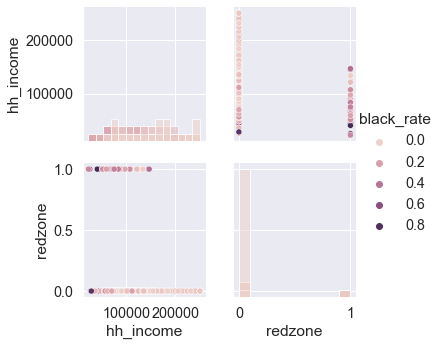

In [137]:
#Look at correlation pairplots
g = sns.PairGrid(lr_df, hue="black_rate")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
g
#no linear correlation noted - do not drop any variables from our model at this point

In [138]:
corr = lr_df.corr()
corr.style.background_gradient(cmap='coolwarm')
#confirms pairplots

,hh_income,black_rate,redzone
hh_income,1.000000,-0.419612,-0.297738
black_rate,-0.419612,1.000000,0.270889
redzone,-0.297738,0.270889,1.000000


In [139]:
#Create features and target pandas using lr_df dataset, and "redzone" as the target variable
X = lr_df.iloc[:,0:-1] 
y = lr_df["redzone"]

#check X to verify that target column has been removed and only features remain
X.head()

,hh_income,black_rate
0,208929,0.020197
1,135208,0.012500
2,218173,0.189774
3,172778,0.110861
4,172778,0.110861


In [140]:
#Break data into train and test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20, random_state=0)

In [141]:
#Call to apply model
LogReg = LogisticRegression()


scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

LogReg.fit(X_train,y_train)


y_pred=LogReg.predict(X_test)

In [142]:
print('Classes', LogReg.classes_)
print('Intercept',LogReg.intercept_)
print("Coefficients", LogReg.coef_ )

Classes [0 1]
Intercept [-3.02834961]
Coefficients [[-1.53100819  0.30527356]]


In [143]:
print("Accuracy", LogReg.score(X_test, y_test))
print(classification_report(y_test, LogReg.predict(X_test)))

Accuracy 0.8823529411764706
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        89
           1       1.00      0.08      0.14        13

    accuracy                           0.88       102
   macro avg       0.94      0.54      0.54       102
weighted avg       0.90      0.88      0.84       102



In [144]:
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

array([[89,  0],
       [12,  1]])

Text(0.5, 527.9871999999999, 'Predicted label')

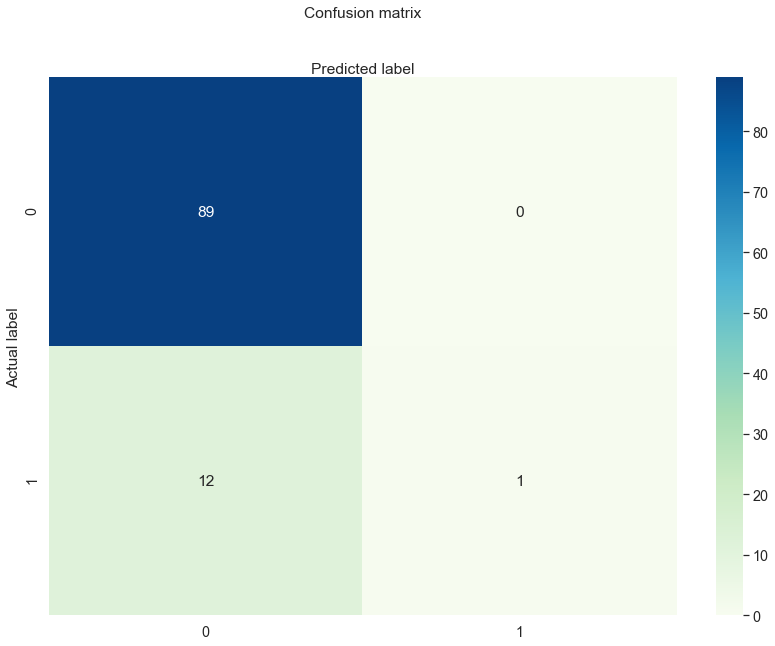

In [145]:
categories = [0,1] 
fig, ax = plt.subplots()
plt.xticks([0,1], categories)
plt.yticks([0,1], categories)
# create heatmap
sns.heatmap(pd.DataFrame(conf_mat), annot=True, cmap="GnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#We will catch  1 and miss 13 of the "at_risk" category ---> likely unacceptable since this is the class we would like to see 
#We will catch all 88   of the "no risk" category ----> highly accurate for majority class

In [146]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Accuracy: 0.8823529411764706
Precision: 1.0
Recall: 0.07692307692307693


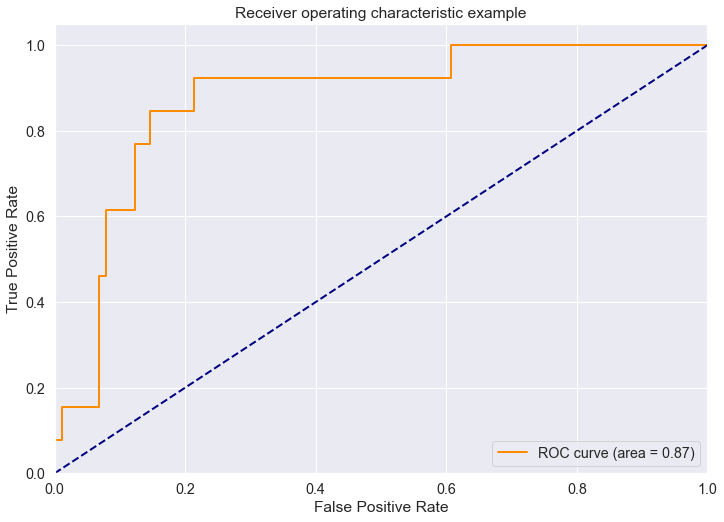

In [147]:
y_pred_proba = LogReg.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
        lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show() 
#0.88 ROC value indicates the model is good; not sure it's that great
##Unable to try using SMOTE in order to increase "at risk" minority group due to package conflicts

In [148]:
#LOGISTIC REGRESSION WITH IMBALANCED DATA IS NOT SATISFACTORY - WE CAN TRY DECISION TREE/random forest
# load library
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

# fit the predictor and target
rfc.fit(X_train, y_train)

# predict
rfc_predict = rfc.predict(X_test)# check performance
print('ROCAUC score:',roc_auc_score(y_test, rfc_predict))
print('Accuracy score:',accuracy_score(y_test, rfc_predict))
print('F1 score:',f1_score(y_test, rfc_predict))
#Well, with an f1 score meaningless, this is worse than Logistic Regression Model

ROCAUC score: 0.5103716508210889
Accuracy score: 0.8333333333333334
F1 score: 0.10526315789473684


In [90]:
#CREATE MAPS

In [149]:
#Split geo-point to retrieve latitude and longitude
block_split = maps_df["geo_location"].str.split(" ", n = 5, expand = True)
print(block_split)


         0            1           2
0    POINT  (-77.175624  39.211873)
1    POINT  (-77.148754  39.211605)
2    POINT  (-77.141329  39.207148)
3    POINT  (-77.144806  39.147649)
4    POINT  (-77.144806  39.147649)
..     ...          ...         ...
505  POINT  (-77.226526  38.996884)
506  POINT  (-77.159447  39.031472)
507  POINT  (-77.153453  39.027533)
508  POINT  (-77.150306  39.023799)
509  POINT  (-77.149295  39.024606)

[510 rows x 3 columns]


In [150]:
#from split create columns: "latitude", "longitude", and 
#"location" for use in maps/gpd
maps_df["longitude"] = block_split.iloc[:,1]
maps_df["longitude"] = maps_df["longitude"].str.replace("(", "")
maps_df["latitude"] = block_split.iloc[:,2]
maps_df["latitude"] = maps_df["latitude"].str.replace(")", "")
maps_df["longitude"] = pd.to_numeric(maps_df["longitude"])
maps_df["latitude"] = pd.to_numeric(maps_df["latitude"])
maps_df.head()


,block,city,hh_income,pop_total,pop_black,sum_col,tow_rate,black_rate,level_0,index,count_col,geo_location,longitude,latitude
0,7001012,Gaithersburg,208929,1931,39,1,0.000518,0.020197,0,5828,1,POINT (-77.175624 39.211873),-77.175624,39.211873
1,7001013,Gaithersburg,135208,800,10,2,0.002500,0.012500,1,5235,1,POINT (-77.148754 39.211605),-77.148754,39.211605
2,7001032,Gaithersburg,218173,1017,193,1,0.000983,0.189774,3,5839,1,POINT (-77.141329 39.207148),-77.141329,39.207148
3,7001033,Derwood,172778,3112,345,12,0.003856,0.110861,4,5766,2,POINT (-77.144806 39.147649),-77.144806,39.147649
4,7001033,Gaithersburg,172778,3112,345,6,0.001928,0.110861,4,5766,2,POINT (-77.144806 39.147649),-77.144806,39.147649


In [151]:
maps_gpd = gpd.GeoDataFrame(maps_df, geometry=gpd.points_from_xy(maps_df.latitude, maps_df.longitude))
maps_gpd.info

<bound method DataFrame.info of        block          city  hh_income  pop_total  pop_black  sum_col  \
0    7001012  Gaithersburg     208929       1931         39        1   
1    7001013  Gaithersburg     135208        800         10        2   
2    7001032  Gaithersburg     218173       1017        193        1   
3    7001033       Derwood     172778       3112        345       12   
4    7001033  Gaithersburg     172778       3112        345        6   
..       ...           ...        ...        ...        ...      ...   
505  7060083       Potomac     231250       2594         36        1   
506  7060101       Potomac     111500       1903        378        1   
507  7060121      Bethesda      62000        892        121       35   
508  7060122      Bethesda      70132       1335        235        1   
509  7060123      Bethesda      59205       1032        200       67   

     tow_rate  black_rate  level_0  index  count_col  \
0    0.000518    0.020197        0   5828      

In [152]:
#New map of tow_rate; areas experiencing greater than upper fence 0.0592

m = folium.Map(location=[39.211873, -77.175624],
                     tiles='stamentoner',
                     zoom_start=12,max_bounds=True)

marker_cluster = folium.plugins.MarkerCluster()

#Create a list of coordinate for heatmap input
outlier_df = maps_gpd[maps_gpd["tow_rate"] >= ufence]
locations = list(zip(outlier_df["latitude"], outlier_df["longitude"]))
from folium.plugins import HeatMap
HeatMap(locations).add_to(folium.FeatureGroup(name='Heat Map').add_to(m))
folium.LayerControl().add_to(m)
m.save('map_heatuf.html')
m

In [154]:
#New map of tow_rate; areas experiencing >=0.0919% 

m1 = folium.Map(location=[39.211873, -77.175624],
                     tiles='stamentoner',
                     zoom_start=11,max_bounds=True)

marker_cluster = folium.plugins.MarkerCluster()

#Create a list of coordinate + weight trios for heatmap input
outlier_df = maps_gpd[maps_gpd["tow_rate"] >= extreme_cutoff]
locations = list(zip(outlier_df["latitude"], outlier_df["longitude"], outlier_df["tow_rate"]))
from folium.plugins import HeatMap
HeatMap(locations).add_to(folium.FeatureGroup(name='Heat Map').add_to(m1))
folium.LayerControl().add_to(m1)

m1



In [96]:
#MAKE MAP OF OUTLIERS WITH TOOLTIP SHOWING TOWING RATE

In [155]:
#Set new map general area
ch=folium.Map(location=[39.211873, -77.175624])
ch

In [156]:
#fix size of map
from branca.element import Figure
fig=Figure(width=550,height=350)

In [157]:
ch=folium.Map(width=550,height=350,location=[39.211873, -77.175624],zoom_start=11,min_zoom=8,max_zoom=14)
fig.add_child(ch)
ch

In [158]:
#Download Maryland County shapefiles as a geopanda called data0 (for now I have it saved on my computer)
url = "/Users/elizabethclick/Downloads/cb_2018_24_bg_500k/cb_2018_24_bg_500k.shp"
fol_plugin = gpd.read_file(url)
data0 = gpd.GeoDataFrame(fol_plugin)
print(data0.head())
#Refine all counties to Montgomery County only in data1 geopanda of geodata shapes
data1 = data0[data0['COUNTYFP'] == '031'].reset_index()
data1.info()
data1["block"] = data1["TRACTCE"] + data1["BLKGRPCE"]
data1['block'] = data1['block'].astype(int)
#data1.loc["block"] = data1["block"].astype(int)
#data1 = data1.drop_duplicates(subset="GEOID", keep='first', inplace=False, ignore_index=False)
data1 = data1.dropna()
data1.head()
data1.info()

  STATEFP COUNTYFP TRACTCE BLKGRPCE               AFFGEOID         GEOID NAME  \
0      24      047  980000        1  1500000US240479800001  240479800001    1   
1      24      019  970900        2  1500000US240199709002  240199709002    2   
2      24      003  706302        3  1500000US240037063023  240037063023    3   
3      24      027  606606        1  1500000US240276066061  240276066061    1   
4      24      005  491201        1  1500000US240054912011  240054912011    1   

  LSAD      ALAND     AWATER  \
0   BG   36014136  196706380   
1   BG  264765218  196678699   
2   BG     500847     785990   
3   BG     709671          0   
4   BG    1126592          0   

                                            geometry  
0  POLYGON ((-75.37851 38.02457, -75.37755 38.026...  
1  MULTIPOLYGON (((-76.06544 38.12980, -76.06461 ...  
2  POLYGON ((-76.48555 38.97298, -76.48098 38.977...  
3  POLYGON ((-76.82290 39.21282, -76.82172 39.213...  
4  POLYGON ((-76.58843 39.40161, -76.58537 39

In [159]:
ch_df = data1.merge(maps_gpd, how='inner', on='block')
ch_df["black_rate"] = ch_df["pop_black"] / ch_df["pop_total"]
ch_df.head() 
sum(ch_df["pop_total"])
len(ch_df)

510

In [160]:
ch_subset = ch_df[["block", "hh_income", "tow_rate", "black_rate", "count_col", "geometry_x", "geometry_y", "latitude", "longitude"]].copy()

In [163]:
#DISPLAY DATAFRAME FOR MAPS
ch_subset.info()
ch_subset["tow_rate"] = ch_subset["tow_rate"].round(4)
ch_subset["black_rate"] = ch_subset["black_rate"].round(4)
markers = list(ch_subset[['latitude', 'longitude']].itertuples(index=False, name=None))
ch_subset["marks"] = markers
ch_subset["values_popup"] =  "Towing_rate: " + ch_subset["tow_rate"].astype(str) + "; " +  "Black_pop_rate: " + ch_subset["black_rate"].astype(str) + "; " + "Hsehld_income: " + ch_subset["hh_income"].astype(str)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 0 to 509
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   block       510 non-null    int64   
 1   hh_income   510 non-null    int64   
 2   tow_rate    510 non-null    float64 
 3   black_rate  510 non-null    float64 
 4   count_col   510 non-null    int64   
 5   geometry_x  510 non-null    geometry
 6   geometry_y  510 non-null    geometry
 7   latitude    510 non-null    float64 
 8   longitude   510 non-null    float64 
dtypes: float64(4), geometry(2), int64(3)
memory usage: 39.8 KB


In [164]:
# Creating Basemap
fig4=Figure(height=350,width=550)
ch1=folium.Map(location=[39.15010, -77.06276],tiles='cartodbpositron',zoom_start=11)
fig4.add_child(ch1)

# Adding Custom Markers
folium.Marker(location=[39.04311, -77.05381], popup='Custom Marker 1',tooltip='<strong>Click here to see Popup</strong>',icon=folium.Icon(color='red',icon='none')).add_to(ch1)

ch1

In [165]:
#THIS MAP SHOWS RATES > UPPER FENCE .0592

outliers_df = ch_subset[ch_subset["tow_rate"] >= ufence]

map_outliers = folium.Map(location=[39.15010, -77.06276], zoom_start=11)

for i,r in outliers_df.iterrows():
    folium.Marker(location=r['marks'],
                  popup = r['values_popup'],
                  tooltip='Click for information').add_to(map_outliers)
map_outliers.save('map_ufence.html')
map_outliers

In [166]:
#Using GESD for otlier cutoff - 0.0919
aboveavg_df = ch_subset[ch_subset["tow_rate"] >= extreme_cutoff]

map_aboveavg = folium.Map(location=[39.15010, -77.06276], zoom_start=11)

for i,r in aboveavg_df.iterrows():
    folium.Marker(location=r['marks'],
                  popup = r['values_popup'],
                  tooltip='Click for information').add_to(map_aboveavg)
map_aboveavg.save('map_GESD.html')    
map_aboveavg
